# Biodiversity Intactness Index Change in the Phoenix Subdivision (2017–2020)

**Name:** Jay Kim

**GitHub repository:** https://github.com/jwonyk/biodiversity-intactness-index-change

## About

#### Purpose
This repository contains the analysis for a project examining changes in the Biodiversity Intactness Index (BII) in the Phoenix subdivision of Maricopa County, AZ, from 2017 to 2020. Using 100 m BII data, the project explores how rapid urban growth may be affecting local biodiversity.

#### Highlights
- Extracting and clipping BII rasters for 2017 and 2020 to the Phoenix subdivision boundary.
- Calculating the percentage of the subdivision area with BII ≥ 0.75 for both years.
- Mapping areas that lost high BII values (≥ 0.75) between 2017 and 2020.
- Situating the Phoenix subdivision within its broader geographic and urban context using additional vector/raster data and basemaps.

#### About the data
- **Biodiversity Intactness Index (BII)**: BII data are taken from the `io-biodiversity` collection on the Microsoft Planetary Computer, which provides global 100 m BII projections for 2017–2020. For this project, the 2017 and 2020 rasters covering the Phoenix subdivision (bounding box: `[-112.826843, 32.974108, -111.184387, 33.863574]`) are loaded and then clipped to the Phoenix subdivision boundary to calculate metrics such as the percentage of area with BII ≥ 0.75.

- **Phoenix subdivision boundary**: The Phoenix subdivision boundary comes from the Census County Subdivision TIGER/Line shapefiles for Arizona. This polygon defines the analysis area, is used to clip the BII rasters, and provides geographic context for mapping within Maricopa County and the surrounding region.

#### References
- Microsoft Planetary Computer, _Biodiversity Intactness Index (BII) Time Series, io-biodiversity Collection_, 2017–2020 [data file]. Available from the Microsoft Planetary Computer STAC catalog. [Accessed: Dec. 1, 2025]

- U.S. Census Bureau, _County Subdivision Shapefiles, Arizona (TIGER/Line)_ [data file]. Available from the U.S. Census Bureau TIGER/Line shapefile download portal. [Accessed: Dec. 1, 2025]

## Setup
Load required Python packages and configure the workspace.

In [1]:
# Load in all necessary packages
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import numpy as np
import contextily as ctx
from shapely.geometry import box

from pystac_client import Client  # To access STAC catalogs
import planetary_computer as pc  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images
from geogif import gif   # To create the GIF

## Read in Data
Import the Census TIGER/Line shapefile and filter to the Phoenix subdivision. 

In [2]:
# Load all county subdivisions for AZ
subdivisions = gpd.read_file('data/tl_2020_04_cousub/tl_2020_04_cousub.shp')  

# Filter to Phoenix subdivision
phoenix_subdivisions = subdivisions[subdivisions['NAME'] == 'Phoenix'].to_crs(epsg = 3857)

## Access

Query the Microsoft Planetary Computer STAC API for 2017 and 2020 BII rasters. We use the Client function from the `pystac_client` package to access the catalog:

In [3]:
# Set bounding box
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Access STAC catalog
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search BII raster for 2017 & 2020
search_2017 = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = '2017-01-01/2017-12-31')

search_2020 = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = '2020-01-01/2020-12-31')

# Extract matching item from each search
item_2017 = list(search_2017.items())[0]
item_2020 = list(search_2020.items())[0]

# Find the asset key
item_2017.assets.keys(), item_2020.assets.keys()

(dict_keys(['data', 'tilejson', 'rendered_preview']),
 dict_keys(['data', 'tilejson', 'rendered_preview']))

## Read in BII Rasters

Open the raster assets into `xarray` objects and inspect dimensions and CRS.

In [4]:
# Access the GeoTIFF from STAC
asset_2017 = pc.sign(item_2017.assets['data'])
asset_2020 = pc.sign(item_2020.assets['data'])

# Read in raster to xarray DataArrays to clip and mask
bii_2017 = rioxr.open_rasterio(asset_2017.href).squeeze()
bii_2020 = rioxr.open_rasterio(asset_2020.href).squeeze()

# Inspect the data
bii_2017, bii_2017.shape, bii_2017.rio.crs

## Clip Rasters to Phoenix Subdivision

Match CRS between raster and vector data, then clip the rasters to the subdivision boundary.

In [7]:
# Match CRS before clipping
phoenix_subdivisions_projection = phoenix_subdivisions.to_crs(bii_2017.rio.crs)

# Clip the Phoenix subdivision to reduce size and keep only pixels inside
bii_2017_clip = (bii_2017.rio.clip_box(*phoenix_subdivisions_projection.total_bounds)
                         .rio.clip(phoenix_subdivisions_projection.geometry, phoenix_subdivisions_projection.crs))
bii_2020_clip = (bii_2020.rio.clip_box(*phoenix_subdivisions_projection.total_bounds)
                         .rio.clip(phoenix_subdivisions_projection.geometry, phoenix_subdivisions_projection.crs))

## Mapping Phoenix Subdivision
Plot the Phoenix subdivision boundary over a basemap

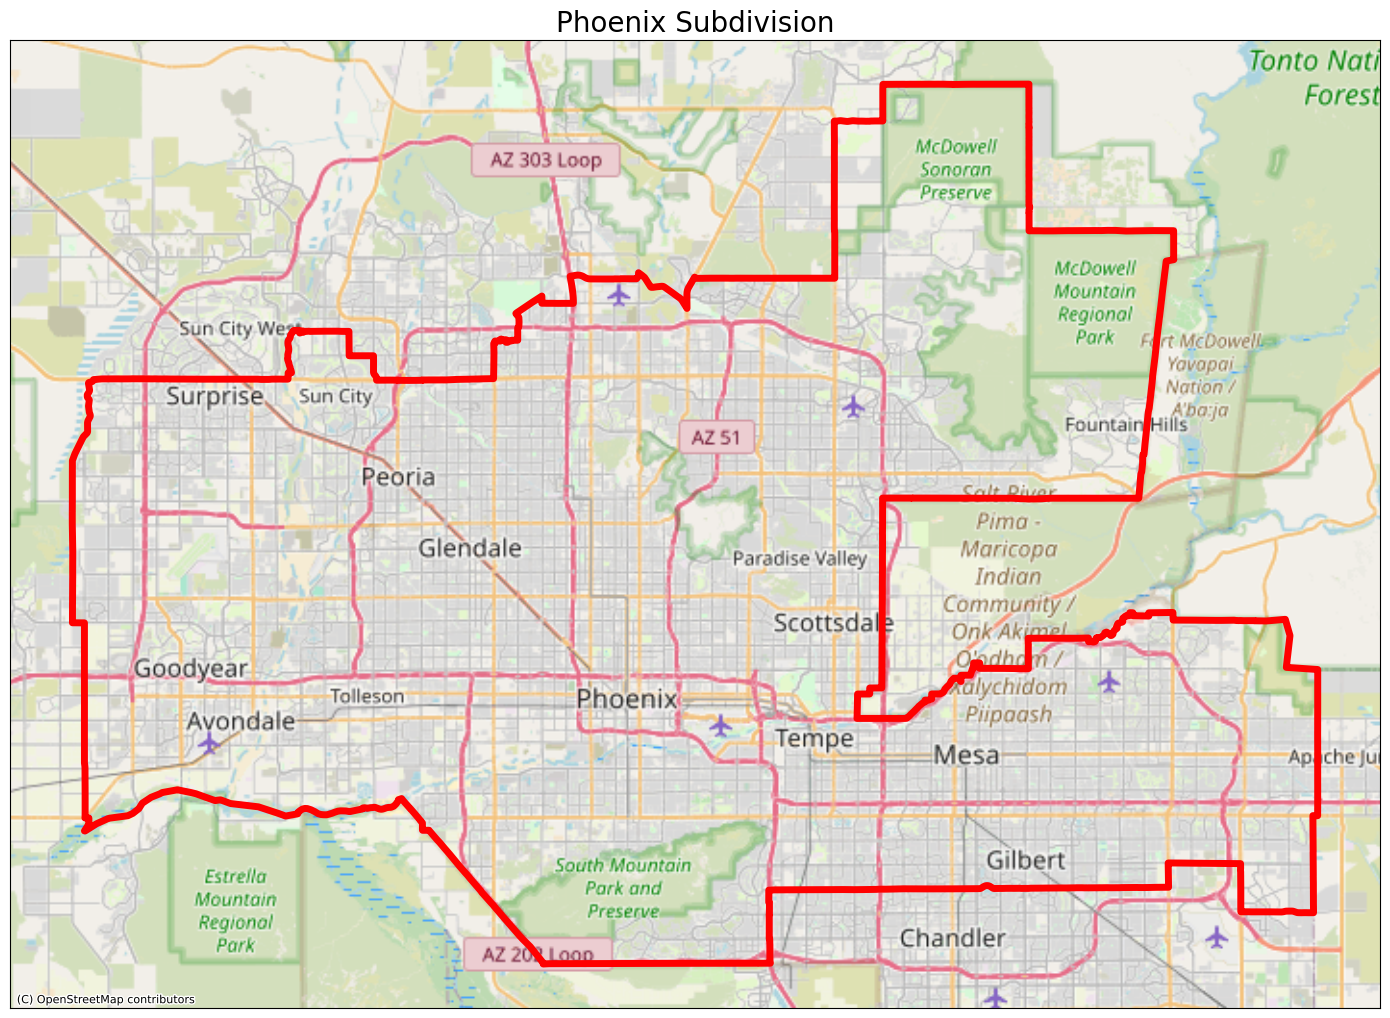

In [12]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize = (14, 12))

# Reproject to Web Mercator for contextily
phoenix_subdivisions_web = phoenix_subdivisions_projection.to_crs(epsg = 3857)

# Plot the subdivision boundary
phoenix_subdivisions_web.boundary.plot(ax = ax, edgecolor = 'red', linewidth = 5)

# Add basemap
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)

# Add title and clean ticks
ax.set_title('Phoenix Subdivision', fontsize = 20, fontweight = 'bold')
ax.set_xticks([])
ax.set_yticks([])

# Improve layout so elements do not overlap
plt.tight_layout()
plt.show()

## Calculate Percentage of Area With BII

Compute the proportion of valid pixels in 2017 and 2020 exceeding the threshold (0.75)

In [9]:
# Threshold representing high biodiversity intactness
threshold = 0.75

# Boolean masks identify pixels meeting the threshold
high_2017 = bii_2017_clip >= threshold
high_2020 = bii_2020_clip >= threshold

# Identify pixels inside the polygon with valid raster data
valid_2017 = ~bii_2017_clip.isnull()
valid_2020 = ~bii_2020_clip.isnull()

# Count qualifying pixels and total valid pixels
n_high_2017 = (high_2017 & valid_2017).sum().item()
n_total_2017 = valid_2017.sum().item()

n_high_2020 = (high_2020 & valid_2020).sum().item()
n_total_2020 = valid_2020.sum().item()

# Compute percentages
pct_2017 = (n_high_2017 / n_total_2017) * 100
pct_2020 = (n_high_2020 / n_total_2020) * 100

print(f"Percentage of of area of the Phoenix subdivision with a BII of at least 0.75 in 2017: {pct_2017:.2f}")
print(f"Percentage of of area of the Phoenix subdivision with a BII of at least 0.75 in 2020: {pct_2020:.2f}")

Percentage of of area of the Phoenix subdivision with a BII of at least 0.75 in 2017: 7.13
Percentage of of area of the Phoenix subdivision with a BII of at least 0.75 in 2020: 6.49


## Result Summary

Using a threshold (BII ≥ 0.75) to test the high biodiversity intactness, the result in shown in the followings: 7.13% of the Phoenix subdivision met this criteria, but it dropped in 2020 to only 6.49%. The decline shows the portion of subdivision which indicates that there are ongoing pressure on habitats.

## Identify Areas That Lost High BII
Create a Boolean mask showing pixels that were ≥0.75 in 2017 but not in 2020.

In [10]:
# Identify pixels that no longer meet the threshold in 2020
lost_high_bii = (high_2017 & valid_2017) & ~(high_2020 & valid_2020)
lost_high_bii

<xarray.DataArray (y: 583, x: 990)> Size: 577kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 8kB -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 5kB 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29
    spatial_ref  int64 8B 0

## Mapping Lost High-BII Areas
Overlay lost-BII pixels (in red) on the 2020 BII raster.

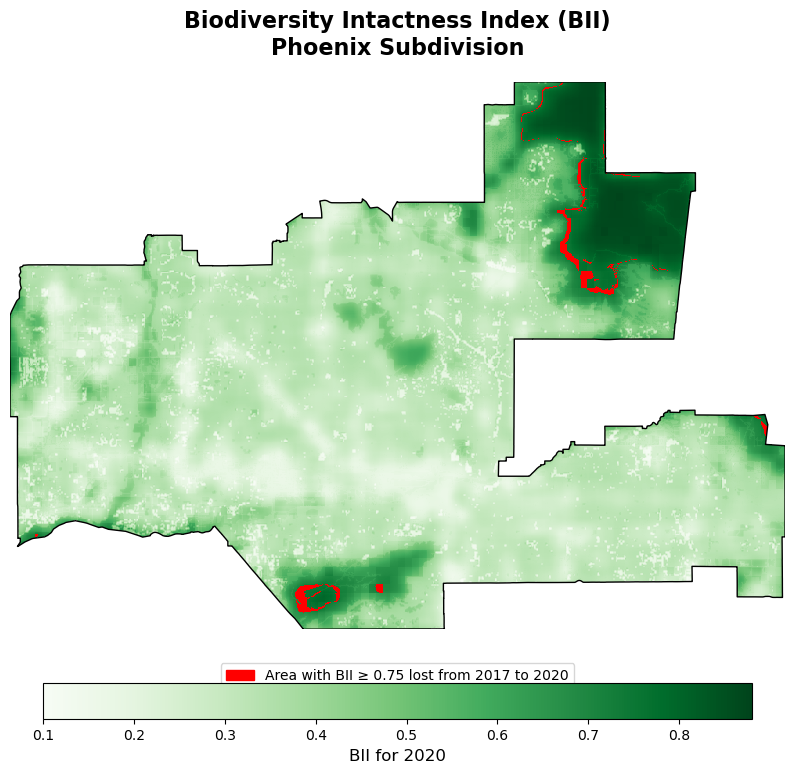

In [11]:
# Create figure
fig, ax = plt.subplots(figsize = (10, 10))

# Ensure `lost_high_bii` is float mask
lost_high_bii_mask = lost_high_bii.where(lost_high_bii, other = np.nan)

# ---------------------------------------------------------------
# Plot BII 2020 as the background 
# ---------------------------------------------------------------

bii_plot = bii_2020_clip.plot(ax = ax, cmap = 'Greens',
                              vmin = 0.1, vmax = 0.88,
                              add_colorbar = False)

# ---------------------------------------------------------------
# Overlay lost high-BII areas in red (fixed red color 
# ---------------------------------------------------------------

lost_high_bii_mask.plot(ax = ax, cmap = ListedColormap(['red']), 
                   alpha = 1.0, add_colorbar = False)

# ---------------------------------------------------------------
# Add Phoenix subdivision outline
# ---------------------------------------------------------------

phoenix_subdivisions_projection.boundary.plot(ax = ax, color = 'black', linewidth = 1)

# ---------------------------------------------------------------
#  Add title
# ---------------------------------------------------------------

ax.set_title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision',
             fontsize = 16, fontweight = 'bold', pad = 20)

ax.axis('off')

# ---------------------------------------------------------------
# Add colorbar for BII 2020
# ---------------------------------------------------------------

cbar = plt.colorbar(bii_plot, ax = ax, orientation = 'horizontal', 
                    fraction = 0.046, pad = 0.07)
cbar.set_label('BII for 2020', fontsize = 12)

# ---------------------------------------------------------------
# Add red legend entry for lost high-BII pixels
# ---------------------------------------------------------------

lost_patch = mpatches.Patch(color = 'red', 
                            label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')

ax.legend(handles = [lost_patch], 
          loc = 'lower center', 
          bbox_to_anchor = (0.5, -0.12))

plt.show()

## Interpretation of BII Change (2017 - 2020)

The map illutrates how biodiversity conditions changed in the Phoenix subdivision between 2017 and 2020. The map shows 2020 BII values in green and highlighted with red in the areas where there has been high biodiversity intactness (BII ≥ 0.75) which no longer meet that threshold. There are larger amount of concentrations of biodiversity loss in the northeastern part of the sudivision while smaller pockets of decline is occuring in the southern and southeastern regions. The urbanization in the area may be correlated reducing local wild habitat and loss of biodiversity.